In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import time
import collections
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Standard Softmax Cross Entropy

In [2]:
model = nn.Sequential(
    nn.Conv2d(1, 20, kernel_size=5, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(20, 50, kernel_size=5, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(800, 500), nn.ReLU(), nn.Dropout(), nn.Linear(500, 10)).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_dataset = datasets.MNIST('/home/centos/data', train=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataset = datasets.MNIST('/home/centos/data', train=False, transform=transforms.ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)

std_hist = collections.defaultdict(list)
for epoch in range(20):
    model.train()
    train_loss, train_acc, train_prob_pos, train_prob_neg = 0., 0., 0., 0.
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        train_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        train_prob_pos += max_probs[mask].sum().item()
        train_prob_neg += max_probs[~mask].sum().item()
        
    model.eval()
    valid_loss, valid_acc, valid_prob_pos, valid_prob_neg = 0., 0., 0., 0.
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        valid_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        valid_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        valid_prob_pos += max_probs[mask].sum().item()
        valid_prob_neg += max_probs[~mask].sum().item()
        
    std_hist['train_loss'].append(train_loss / len(train_loader))
    std_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    std_hist['train_prob_pos'].append(train_prob_pos / (train_acc + 1e-6))
    std_hist['train_prob_neg'].append(train_prob_neg / (len(train_loader.dataset) - train_acc))
    
    std_hist['valid_loss'].append(valid_loss / len(valid_loader))
    std_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    std_hist['valid_prob_pos'].append(valid_prob_pos / (valid_acc + 1e-6))
    std_hist['valid_prob_neg'].append(valid_prob_neg / (len(valid_loader.dataset) - valid_acc))
        
    print('Epoch {:02d}: train_loss {:.3f}, train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}'.format(
        epoch, std_hist['train_loss'][-1], std_hist['train_acc'][-1], std_hist['train_prob_pos'][-1], std_hist['train_prob_neg'][-1], std_hist['valid_loss'][-1], std_hist['valid_acc'][-1], std_hist['valid_prob_pos'][-1],
        std_hist['valid_prob_neg'][-1],
    ))

Epoch 00: train_loss 0.218, train_acc 0.932, train_pos 0.944, train_neg 0.507, valid_loss 0.054, valid_acc 0.983, valid_pos 0.982, valid_neg 0.705
Epoch 01: train_loss 0.062, train_acc 0.981, train_pos 0.983, train_neg 0.706, valid_loss 0.033, valid_acc 0.990, valid_pos 0.990, valid_neg 0.708
Epoch 02: train_loss 0.045, train_acc 0.986, train_pos 0.988, train_neg 0.710, valid_loss 0.028, valid_acc 0.991, valid_pos 0.994, valid_neg 0.725
Epoch 03: train_loss 0.035, train_acc 0.989, train_pos 0.991, train_neg 0.721, valid_loss 0.032, valid_acc 0.990, valid_pos 0.994, valid_neg 0.756
Epoch 04: train_loss 0.029, train_acc 0.991, train_pos 0.993, train_neg 0.731, valid_loss 0.023, valid_acc 0.992, valid_pos 0.995, valid_neg 0.747
Epoch 05: train_loss 0.023, train_acc 0.993, train_pos 0.994, train_neg 0.733, valid_loss 0.021, valid_acc 0.993, valid_pos 0.996, valid_neg 0.760
Epoch 06: train_loss 0.020, train_acc 0.993, train_pos 0.995, train_neg 0.730, valid_loss 0.024, valid_acc 0.992, vali

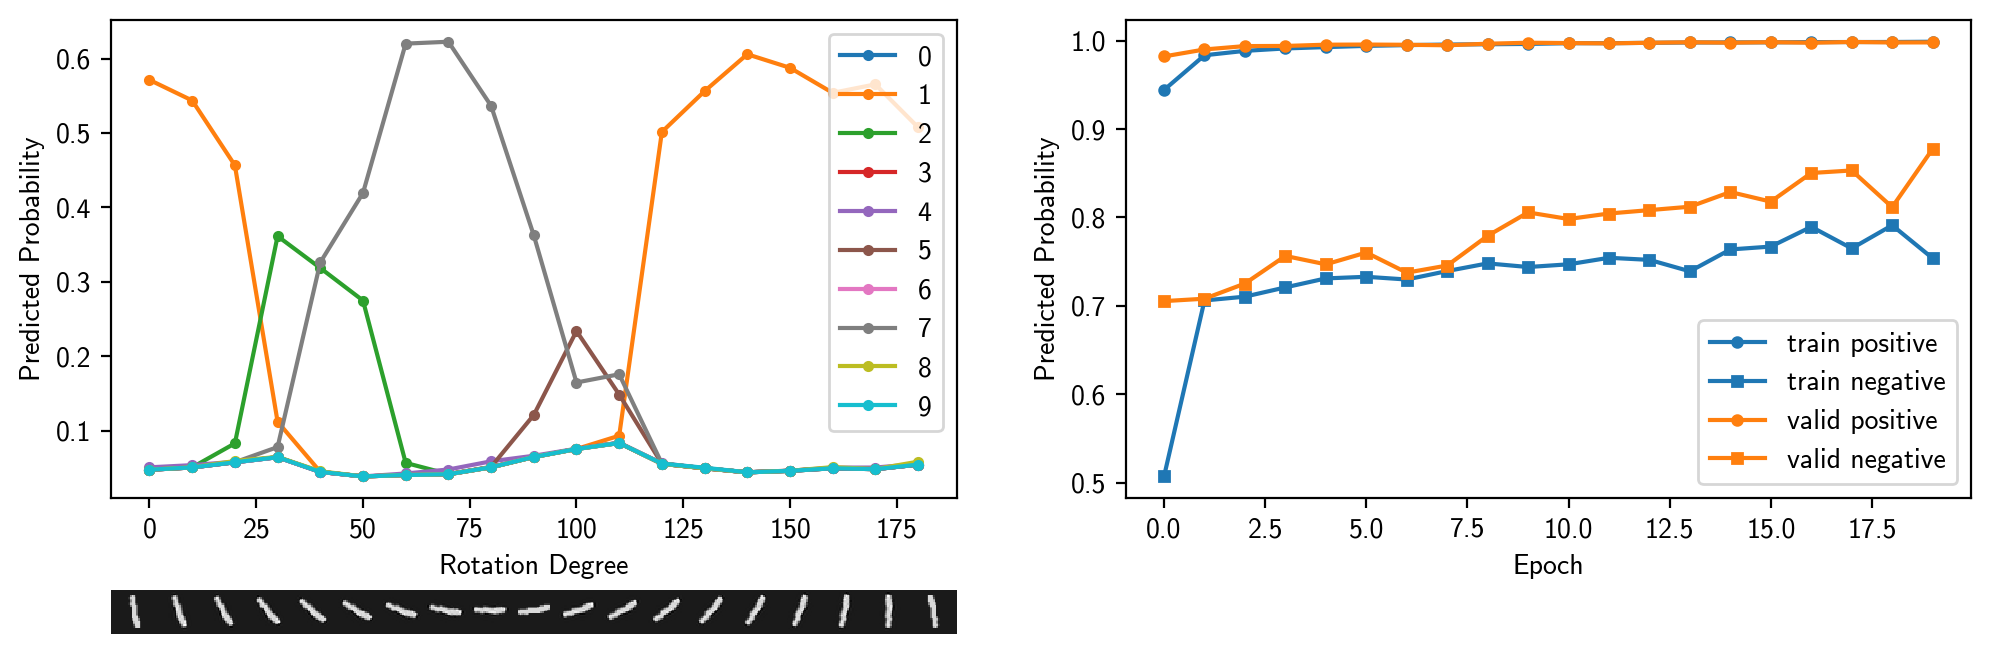

In [4]:
angles = np.linspace(0, 180, 19)
rotated_ones = np.stack([ndimage.rotate(train_dataset.data[6].float() / 255., angle=angle, reshape=False) for angle in angles], axis=0)
rotated_ones = torch.from_numpy(rotated_ones).unsqueeze(1)
alphas = F.softplus(model(rotated_ones.cuda())) + 1
probs = (alphas / alphas.sum(dim=-1, keepdims=True)).detach().cpu().numpy()

fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 4), sharex='col')
for idx in np.arange(10)[probs.mean(axis=0) > 0.05]:
    ax0.plot(angles, probs[:, idx], marker='.', label=idx)
ax0.legend()
ax0.set_xlabel('Rotation Degree')
ax0.set_ylabel('Predicted Probability')

div0 = make_axes_locatable(ax0)
cax0 = div0.new_vertical(size="10%", pad=0.45, pack_start=True)
fig.add_axes(cax0)
cax0.imshow(rotated_ones.permute(2, 0, 3, 1).reshape(28, -1), cmap='gray')
cax0.axis('off');

ax1.plot(range(len(std_hist['train_prob_pos'])), std_hist['train_prob_pos'], marker='.', c='C0', label='train positive', markersize=7)
ax1.plot(range(len(std_hist['train_prob_neg'])), std_hist['train_prob_neg'], marker='s', c='C0', label='train negative', markersize=3.5)
ax1.plot(range(len(std_hist['valid_prob_pos'])), std_hist['valid_prob_pos'], marker='.', c='C1', label='valid positive', markersize=7)
ax1.plot(range(len(std_hist['valid_prob_neg'])), std_hist['valid_prob_neg'], marker='s', c='C1', label='valid negative', markersize=3.5)
ax1.set_ylabel('Predicted Probability')
ax1.set_xlabel('Epoch')
ax1.legend();

div1 = make_axes_locatable(ax1)
cax1 = div1.new_vertical(size="10%", pad=0.45, pack_start=True)
fig.add_axes(cax1)
cax1.axis('off');

### Bayes Risk with Squared Loss

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 20, kernel_size=5, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(20, 50, kernel_size=5, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(800, 500), nn.ReLU(), nn.Dropout(0.5), nn.Linear(500, 10)).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_dataset = datasets.MNIST('/home/centos/data', train=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataset = datasets.MNIST('/home/centos/data', train=False, transform=transforms.ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)
flat_dirichlet = D.Dirichlet(torch.tensor([1.] * 10, dtype=torch.float32, requires_grad=False).cuda())

global_idx, mse_hist = 0, collections.defaultdict(list)
for epoch in range(20):
    start_time = time.time()
    model.train()
    train_loss, train_acc, train_alpha_pos, train_alpha_neg, grad_norm = 0., 0., 0., 0., 0.
    for batch_idx, (images, labels) in enumerate(train_loader):
        global_idx += 1
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        alphas = F.softplus(logits) + 1
        alpha0 = alphas.sum(dim=-1, keepdims=True)
        means = alphas / alpha0
        
        targets = F.one_hot(labels, num_classes=10)
        loss1 = torch.sum((targets - means) ** 2, dim=-1).mean()
        loss2 = torch.sum(means * (1 - means) / (alpha0 + 1), dim=-1).mean()
        loss3 = min(1.0, global_idx / (10. * len(train_loader))) * D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
        loss = loss1 + loss2 + loss3
            
        optimizer.zero_grad()
        loss.backward()
        grad_norm += np.sqrt(sum(p.grad.data.norm() ** 2 for p in model.parameters() if p.grad is not None).detach().cpu())
        optimizer.step()
        train_loss += loss.item()
        mask = alphas.argmax(dim=1).eq(labels)
        train_acc += mask.sum().item()
        train_alpha_pos += alpha0[mask].sum().item()
        train_alpha_neg += alpha0[~mask].sum().item()   
        
    model.eval()
    valid_loss, valid_acc, valid_alpha_pos, valid_alpha_neg = 0., 0., 0., 0.
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        alphas = F.softplus(logits) + 1
        alpha0 = alphas.sum(dim=-1, keepdims=True)
        means = alphas / alpha0
        
        targets = F.one_hot(labels, num_classes=10)
        loss1 = torch.sum((targets - means) ** 2, dim=-1).mean()
        loss2 = torch.sum(means * (1 - means) / (alpha0 + 1), dim=-1).mean()
        loss3 = min(1.0, global_idx / (10. * len(train_loader))) * D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
        loss = loss1 + loss2 + loss3
        valid_loss += loss.item()
        
        mask = alphas.argmax(dim=1).eq(labels)
        valid_acc += mask.sum().item()
        valid_alpha_pos += alpha0[mask].sum().item()
        valid_alpha_neg += alpha0[~mask].sum().item()
    
    mse_hist['train_loss'].append(train_loss / len(train_loader))
    mse_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    mse_hist['train_alpha_pos'].append(train_alpha_pos / (train_acc + 1e-6))
    mse_hist['train_alpha_neg'].append(train_alpha_neg / (len(train_loader.dataset) - train_acc))
    
    mse_hist['valid_loss'].append(valid_loss / len(valid_loader))
    mse_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    mse_hist['valid_alpha_pos'].append(valid_alpha_pos / (valid_acc + 1e-6))
    mse_hist['valid_alpha_neg'].append(valid_alpha_neg / (len(valid_loader.dataset) - valid_acc))
    
    print('Epoch {:02d}: train_loss {:.3f}, train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}, grad_norm {:.3f}, time {:.3f}s'.format(
        epoch, mse_hist['train_loss'][-1], mse_hist['train_acc'][-1], mse_hist['train_alpha_pos'][-1], mse_hist['train_alpha_neg'][-1], mse_hist['valid_loss'][-1],
        mse_hist['valid_acc'][-1], mse_hist['valid_alpha_pos'][-1], mse_hist['valid_alpha_neg'][-1], grad_norm / len(train_loader), time.time() - start_time
    ))

Epoch 00: train_loss 0.218, train_acc 0.901, train_pos 60.796, train_neg 27.848, valid_loss 0.098, valid_acc 0.968, valid_pos 79.655, valid_neg 23.347, grad_norm 0.652, time 8.777s
Epoch 01: train_loss 0.113, train_acc 0.967, train_pos 84.183, train_neg 22.945, valid_loss 0.078, valid_acc 0.979, valid_pos 90.161, valid_neg 17.663, grad_norm 0.712, time 9.029s
Epoch 02: train_loss 0.102, train_acc 0.973, train_pos 95.367, train_neg 20.918, valid_loss 0.076, valid_acc 0.981, valid_pos 100.634, valid_neg 18.494, grad_norm 0.741, time 8.979s
Epoch 03: train_loss 0.099, train_acc 0.973, train_pos 102.172, train_neg 17.268, valid_loss 0.075, valid_acc 0.978, valid_pos 104.082, valid_neg 14.836, grad_norm 0.763, time 10.758s
Epoch 04: train_loss 0.093, train_acc 0.974, train_pos 109.433, train_neg 16.150, valid_loss 0.071, valid_acc 0.979, valid_pos 109.680, valid_neg 13.303, grad_norm 0.759, time 10.732s
Epoch 05: train_loss 0.089, train_acc 0.975, train_pos 116.177, train_neg 15.412, valid_

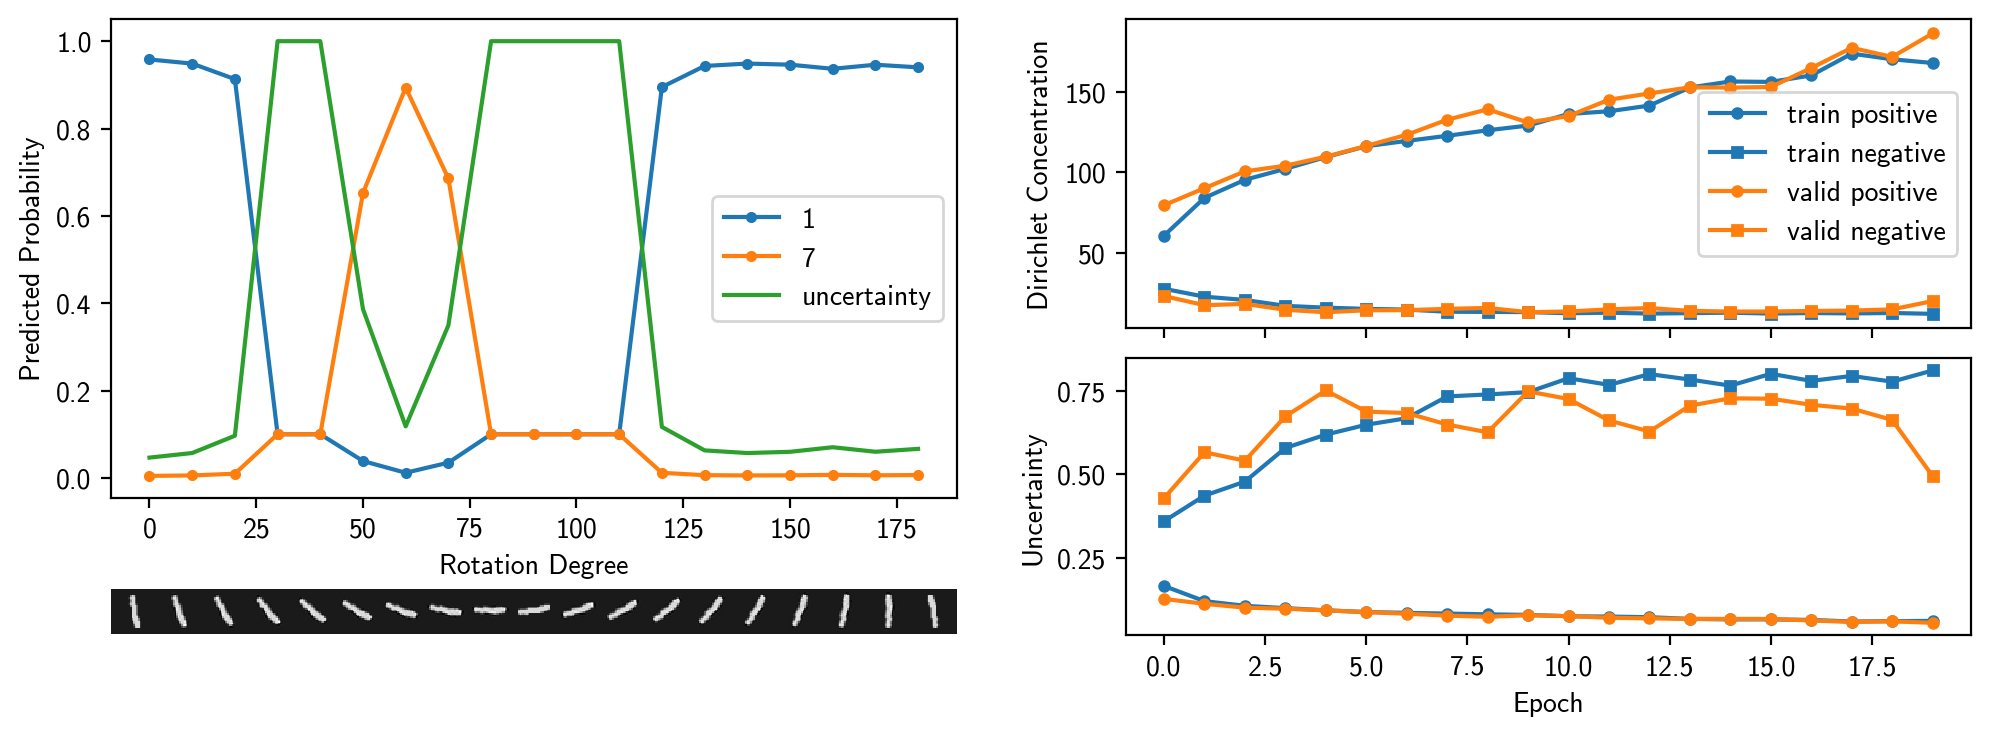

In [8]:
angles = np.linspace(0, 180, 19)
rotated_ones = np.stack([ndimage.rotate(train_dataset.data[6].float() / 255., angle=angle, reshape=False) for angle in angles], axis=0)
rotated_ones = torch.from_numpy(rotated_ones).unsqueeze(1)
alphas = F.softplus(model(rotated_ones.cuda())) + 1
probs = (alphas / alphas.sum(dim=-1, keepdims=True)).detach().cpu().numpy()

fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 4), sharex='col')
for idx in np.arange(10)[probs.mean(axis=0) > 0.1]:
    ax0.plot(angles, probs[:, idx], marker='.', label=idx)
ax0.plot(angles, 10. / alphas.sum(dim=-1).detach().cpu().numpy(), label='uncertainty')
ax0.legend()
ax0.set_xlabel('Rotation Degree')
ax0.set_ylabel('Predicted Probability')

div0 = make_axes_locatable(ax0)
cax0 = div0.new_vertical(size="10%", pad=0.45, pack_start=True)
fig.add_axes(cax0)
cax0.imshow(rotated_ones.permute(2, 0, 3, 1).reshape(28, -1), cmap='gray')
cax0.axis('off');

ax1.plot(range(len(mse_hist['train_alpha_pos'])), mse_hist['train_alpha_pos'], marker='.', c='C0', label='train positive', markersize=7)
ax1.plot(range(len(mse_hist['train_alpha_neg'])), mse_hist['train_alpha_neg'], marker='s', c='C0', label='train negative', markersize=3.5)
ax1.plot(range(len(mse_hist['valid_alpha_pos'])), mse_hist['valid_alpha_pos'], marker='.', c='C1', label='valid positive', markersize=7)
ax1.plot(range(len(mse_hist['valid_alpha_neg'])), mse_hist['valid_alpha_neg'], marker='s', c='C1', label='valid negative', markersize=3.5)
ax1.set_ylabel('Dirichlet Concentration')
ax1.set_xticklabels([])
ax1.legend()

div1 = make_axes_locatable(ax1)
cax1 = div1.new_vertical(size="90%", pad=0.15, pack_start=True)
fig.add_axes(cax1)
cax1.plot(range(len(mse_hist['train_alpha_pos'])), 10./ np.array(mse_hist['train_alpha_pos']), marker='.', markersize=7, c='C0', label='train positive uncertainty')
cax1.plot(range(len(mse_hist['train_alpha_neg'])), 10./ np.array(mse_hist['train_alpha_neg']), marker='s', markersize=3.5, c='C0', label='train negative uncertainty')
cax1.plot(range(len(mse_hist['valid_alpha_pos'])), 10./ np.array(mse_hist['valid_alpha_pos']), marker='.', markersize=7, c='C1', label='valid positive uncertainty')
cax1.plot(range(len(mse_hist['valid_alpha_neg'])), 10./ np.array(mse_hist['valid_alpha_neg']), marker='s', markersize=3.5, c='C1', label='valid negative uncertainty')
cax1.set_xlabel('Epoch')
cax1.set_ylabel('Uncertainty');

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())